# Bayesian Global Optimization in Convolutional Neural Network

## Read SVHN Dataset

In [1]:
from scipy.io import loadmat
x = loadmat('svhn_data/train_32x32.mat')
y = loadmat('svhn_data/test_32x32.mat')
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
train_labels = x['y']

In [3]:
train_features = np.swapaxes(np.swapaxes(np.swapaxes(x['X'],2,3), 1,2), 0,1)

In [4]:
test_labels = y['y']

In [5]:
test_features = np.swapaxes(np.swapaxes(np.swapaxes(y['X'],2,3), 1,2), 0,1)

In [6]:
def display_image(position):
    image = train_features[position, :, : ,:].squeeze()
    plt.title('Example %d. Label: %d' % (position, train_labels[position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

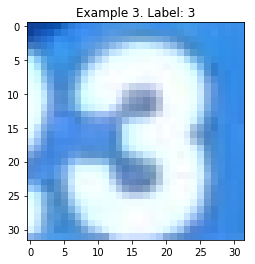

In [7]:
display_image(3)

In [8]:
del x, y

## Explore Dataset

In [9]:
train_labels_count = np.unique(train_labels, return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,1,13861
1,2,10585
2,3,8497
3,4,7458
4,5,6882
5,6,5727
6,7,5595
7,8,5045
8,9,4659
9,10,4948


## Train Test Split

In [10]:
validation = {}
train_features, validation_features, train_labels, validation_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=0)

In [11]:
train_labels.shape

(58605, 1)

In [12]:
print('# of training images:', train_features.shape[0])
print('# of validation images:', validation_features.shape[0])

# of training images: 58605
# of validation images: 14652


## Create sample model

#### Hyperparameters to experiment with

Implement Bayesian Global Optimization to arrive at optimal hyper parameter values for:
1. Starting Learning Rate $\eta_0$
2. Learning Rate Decay $\delta$ where learning-rate $\eta = \frac{\eta_0}{(1+\delta*t)}$ 
3. Mini-batch size: $B$
4. Dropout parameter $p_1$ for first fully connected layer
5. Dropout parameter $p_2$ for second fully connected layer

In [13]:
STARTING_LEARNING_RATE = 0.0001
DECAY = 0.1
BATCH_SIZE = 128
DROPOUT_P1 = 0.001
DROPOUT_P2 = 0.001
EPOCHS = 10

In [14]:
# STARTING_LEARNING_RATE = [0.001,0.01,0.05,0.1]
# DECAY = [0.0000001,0.000001,0.0001]
# # BATCH_SIZE = [32, 64, 128] #256,512,1024]
# BATCH_SIZE = [256,512,1024]
# DROPOUT_P1 = [0.1,0.25,0.5]
# DROPOUT_P2 = [0.1,0.25,0.5]
# EPOCHS = 1

# STARTING_LEARNING_RATE = [0.001,0.01]
# DECAY = [0.0000001,0.00001]
# # BATCH_SIZE = [32, 64, 128] #256,512,1024]
# BATCH_SIZE = [256,512]
# DROPOUT_P1 = [0.1, 0.4]
# DROPOUT_P2 = [0.1, 0.4]
# EPOCHS = 1

In [15]:
X_train, y_train = train_features, to_categorical(train_labels)[:,1:]
# X_train = train_features
X_validation, y_validation = validation_features, to_categorical(validation_labels)[:,1:]

#Comment when running Grid Search
train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [16]:
############ LENET #############
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))
#, kernel_initializer="glorot_uniform", bias_initializer="zeros")


# ############# Proposed Model #############
# model = keras.Sequential()
# model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3), strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
# #model.add(layers.AveragePooling2D())

# model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
# #model.add(layers.AveragePooling2D())
# model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))

# model.add(layers.Flatten())

# model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
# model.add(layers.Dropout(rate=DROPOUT_P1, seed=1))
# model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
# model.add(layers.Dropout(rate=DROPOUT_P2, seed=1))
# model.add(layers.Dense(units=10, activation = 'softmax'))


############# Grid Search #############
# result=[]
# for lr in STARTING_LEARNING_RATE:
#     for b in BATCH_SIZE:
#         for dec in DECAY:
#             for d1 in DROPOUT_P1:
#                 for d2 in DROPOUT_P2:
                    
#                     print(lr, b, dec, d1, d2)
                    
#                     train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=b)
#                     validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=b)

#                     model = keras.Sequential()
#                     model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3), strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
#                     model.add(layers.AveragePooling2D())

#                     model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
#                     model.add(layers.AveragePooling2D())
#                     model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))

#                     model.add(layers.Flatten())

#                     model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
#                     model.add(layers.Dropout(rate=d1, seed=10))
#                     model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
#                     model.add(layers.Dropout(rate=d2, seed=10))
#                     model.add(layers.Dense(units=10, activation = 'softmax'))
                    
#                     model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=lr,decay=dec), metrics=['accuracy'])
                    
# #                     print('# of training images:', train_features.shape[0])
# #                     print('# of validation images:', validation_features.shape[0])

#                     steps_per_epoch = X_train.shape[0]//b
#                     validation_steps = X_validation.shape[0]//b

#                     tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#                     model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
#                                         validation_data=validation_generator, validation_steps=validation_steps, 
#                                         shuffle=False, callbacks=[tensorboard])
                
#                     score = model.evaluate(test_features, to_categorical(test_labels)[:,1:])
#                     result.append(((lr,b,dec,d1,d2),score))
#                     print('Test loss: {} Accuracy: {}'.format(score[0], score[1]))
#                     del train_generator, validation_generator, model

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
#result
#sorted(result, key = lambda x: x[1][1], reverse=True)

In [18]:
model.summary()
#result[0][1][1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

In [19]:
#Comment for Grid Search
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=STARTING_LEARNING_RATE,decay=DECAY), metrics=['accuracy'])

# of training images: 58605
# of validation images: 14652
Epoch 1/10
457/457 [==============================] - 6s 14ms/step - loss: 8.2887 - acc: 0.1358 - val_loss: 8.2050 - val_acc: 0.1369
Epoch 2/10
457/457 [==============================] - 7s 15ms/step - loss: 8.1889 - acc: 0.1348 - val_loss: 8.1514 - val_acc: 0.1349
Epoch 3/10
457/457 [==============================] - 7s 16ms/step - loss: 8.0970 - acc: 0.1342 - val_loss: 8.0705 - val_acc: 0.1345
Epoch 4/10
457/457 [==============================] - 7s 15ms/step - loss: 8.0181 - acc: 0.1337 - val_loss: 8.0050 - val_acc: 0.1323
Epoch 5/10
457/457 [==============================] - 6s 14ms/step - loss: 7.9708 - acc: 0.1325 - val_loss: 7.9575 - val_acc: 0.1325
Epoch 6/10
457/457 [==============================] - 8s 16ms/step - loss: 7.9300 - acc: 0.1323 - val_loss: 7.8936 - val_acc: 0.1320
Epoch 7/10
457/457 [==============================] - 7s 15ms/step - loss: 7.8902 - acc: 0.1323 - val_loss: 7.9171 - val_acc: 0.1301
Epoch 8/10


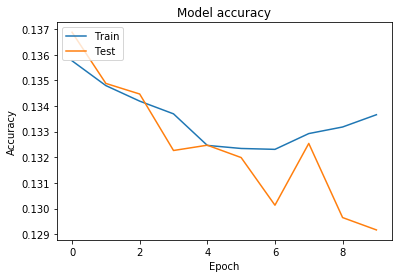

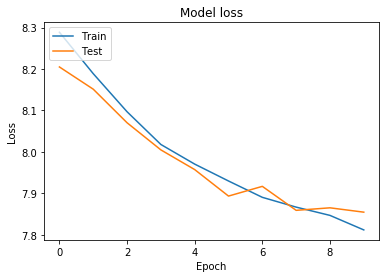

In [23]:
print('# of training images:', train_features.shape[0])
print('# of validation images:', validation_features.shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=False, callbacks=[tensorboard])

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
np.mean(history.history['loss'])

8.994491011678729

In [22]:
score = model.evaluate(test_features, to_categorical(test_labels)[:,1:])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

26032/26032 [==============================] - 5s 202us/step
Test loss: 8.41017639321935
Test accuracy: 0.14543638598647818


larger batch size, watch your weight initializations

equations, figures all labeled and cited. References discussed. Put a few equations, Glorot et.al [1], discuss a couple of papers in related work, section headings

In [16]:
EPOCHS = 20

Epoch 1/10
114/114 [==============================] - 2s 20ms/step - loss: 2.1594 - acc: 0.3602 - val_loss: 1.1916 - val_acc: 0.6271
Epoch 2/10
114/114 [==============================] - 2s 15ms/step - loss: 0.9305 - acc: 0.7182 - val_loss: 0.7989 - val_acc: 0.7644
Epoch 3/10
114/114 [==============================] - 2s 15ms/step - loss: 0.6949 - acc: 0.7966 - val_loss: 0.6755 - val_acc: 0.8018
Epoch 4/10
114/114 [==============================] - 2s 15ms/step - loss: 0.5874 - acc: 0.8285 - val_loss: 0.6191 - val_acc: 0.8258
Epoch 5/10
114/114 [==============================] - 2s 15ms/step - loss: 0.5218 - acc: 0.8496 - val_loss: 0.5532 - val_acc: 0.8462
Epoch 6/10
114/114 [==============================] - 2s 15ms/step - loss: 0.4666 - acc: 0.8653 - val_loss: 0.5152 - val_acc: 0.8521
Epoch 7/10
114/114 [==============================] - 2s 15ms/step - loss: 0.4296 - acc: 0.8772 - val_loss: 0.5066 - val_acc: 0.8613
Epoch 8/10
114/114 [==============================] - 2s 15ms/step - 

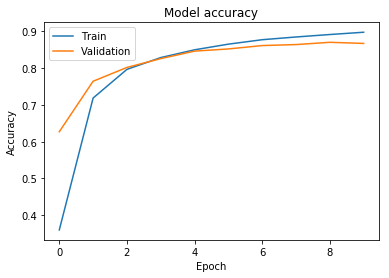

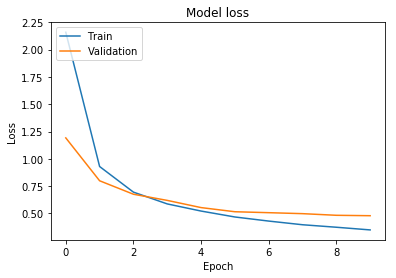

In [34]:
b = 512

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=b)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=b)
############# LENET #############
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))
#, kernel_initializer="glorot_uniform", bias_initializer="zeros")
            
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001,decay=0.0000001), metrics=['accuracy'])
steps_per_epoch = X_train.shape[0]//b
validation_steps = X_validation.shape[0]//b

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=False, callbacks=[tensorboard])

score = model.evaluate(test_features, to_categorical(test_labels)[:,1:])
print('Test loss: {} Accuracy: {}'.format(score[0], score[1]))
# ############# Grid Search #############
# result=[]
# for lr in STARTING_LEARNING_RATE:
#     for b in BATCH_SIZE:
#         for dec in DECAY:
                    
#             print(lr, b, dec)

#             train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=b)
#             validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=b)

#             model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=lr,decay=dec), metrics=['accuracy'])

# #                     print('# of training images:', train_features.shape[0])
# #                     print('# of validation images:', validation_features.shape[0])

#             steps_per_epoch = X_train.shape[0]//b
#             validation_steps = X_validation.shape[0]//b

#             tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#             model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
#                                 validation_data=validation_generator, validation_steps=validation_steps, 
#                                 shuffle=False, callbacks=[tensorboard])

#             score = model.evaluate(test_features, to_categorical(test_labels)[:,1:])
#             result.append(((lr,b,dec),score))
#             print('Test loss: {} Accuracy: {}'.format(score[0], score[1]))

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [4]:
# define an objective function
def objective(args):
    case, val = args
    if case == 'case 1':
        return val
    else:
        return val ** 2


In [5]:
# define a search space
from hyperopt import hp
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

In [10]:
# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 365.90it/s, best loss: 5.279997738664988e-05]


In [11]:
print(best)
# -> {'a': 1, 'c2': 0.01420615366247227}
print(space_eval(space, best))
# -> ('case 2', 0.01420615366247227}

{'a': 1, 'c2': -0.00726635929380387}
('case 2', -0.00726635929380387)


In [12]:
from scipy.io import loadmat
x = loadmat('svhn_data/train_32x32.mat')
y = loadmat('svhn_data/test_32x32.mat')
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense

def create_model(lr = 0.001, decay = 0.0001,DROPOUT_P1 = 0.2,DROPOUT_P2 = 0.2 ):
    
#     model = Sequential()
#     model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
#     model.add(layers.AveragePooling2D())
#    
#     model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
#     model.add(layers.AveragePooling2D())
#     model.add(layers.Flatten())
#    
#     model.add(layers.Dense(units=120, activation='relu'))
#     model.add(layers.Dropout(rate=DROPOUT_P1, seed=1))
#     model.add(layers.Dense(units=84, activation='relu'))
#     model.add(layers.Dropout(rate=DROPOUT_P2, seed=1))
#     model.add(layers.Dense(units=1, activation = 'softmax'))
#     #, kernel_initializer="glorot_uniform", bias_initializer="zeros")
#     model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(lr=lr,decay=decay), metrics=['accuracy'])
     model = keras.Sequential()
     model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3), strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
     #model.add(layers.AveragePooling2D())
    
     model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
     #model.add(layers.AveragePooling2D())
     model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
    
     model.add(layers.Flatten())
    
     model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
     model.add(layers.Dropout(rate=DROPOUT_P1, seed=1))
     model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
     model.add(layers.Dropout(rate=DROPOUT_P2, seed=1))
     model.add(layers.Dense(units=10, activation = 'softmax'))
     model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=lr,decay=decay), metrics=['accuracy'])
     return model

train_labels = x['y']


#[3]:


train_features = np.swapaxes(np.swapaxes(np.swapaxes(x['X'],2,3), 1,2), 0,1)


# [4]:


test_labels = y['y']


# [5]:


test_features = np.swapaxes(np.swapaxes(np.swapaxes(y['X'],2,3), 1,2), 0,1)
train_labels_count = np.unique(train_labels, return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels


# ## Train Test Split



validation = {}
train_features, validation_features, train_labels, validation_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=0)




train_labels.shape




print('# of training images:', train_features.shape[0])
print('# of validation images:', validation_features.shape[0])

#def create_model(lr = 0.001, decay = 0.0001,DROPOUT_P1 = 0.2,DROPOUT_P2 = 0.2 ):
#    
#     model = Sequential()
#     model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
#     model.add(layers.AveragePooling2D())
#    
#     model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
#     model.add(layers.AveragePooling2D())
#     model.add(layers.Flatten())
#    
#     model.add(layers.Dense(units=120, activation='relu'))
#     model.add(layers.Dropout(rate=DROPOUT_P1, seed=1))
#     model.add(layers.Dense(units=84, activation='relu'))
#     model.add(layers.Dropout(rate=DROPOUT_P2, seed=1))
#     model.add(layers.Dense(units=10, activation = 'softmax'))
#     #, kernel_initializer="glorot_uniform", bias_initializer="zeros")
#     model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(lr=lr,decay=decay), metrics=['accuracy'])
#     return model

      

X_train, y_train = train_features, to_categorical(train_labels)[:,1:]
# X_train = train_features
X_validation, y_validation = validation_features, to_categorical(validation_labels)[:,1:]

lr = list(np.logspace(np.log(0.00001), np.log(0.01), num = 100, base=3))
decay = list(np.logspace(np.log(0.0001), np.log(0.1), num = 10, base=2.73))
batch_size = [16,32,64,128,256]
DROPOUT_P2 = np.random.uniform(0.1,0.7,size=(10,))
DROPOUT_P1 = np.random.uniform(0.1,0.7,size=(10,))

#param_random = {'lr' : lr, 'decay' : decay,'batch_size' : batch_size,'DROPOUT_P1' : DROPOUT_P1,'DROPOUT_P2' : DROPOUT_P2, 'batch_size' : batch_size}
param_random = {'lr' : lr}

model = KerasClassifier(build_fn = create_model,verbose=1)
random = RandomizedSearchCV(estimator=model, cv=KFold(2), param_distributions=param_random, 
                          verbose=20,  n_iter=30, n_jobs=1,scoring = 'accuracy')

random_fit= random.fit(X_train, y_train)
random_results = pd.DataFrame(random_fit.cv_results_)
random_results.to_csv("random_search_results.csv")
print(random_fit.best_score_)
print(random_fit.best_estimator_)

# of training images: 58605
# of validation images: 14652
Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV] lr=0.00017301557218123276 .......................................
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
29303/29303 [==============================] - 12s 405us/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

## 